## Tarea 15 del curso CM-072

* Nombre y apellidos:
* Fecha de presentación: 11 de diciembre.

La detección de anomalías es una tarea de machine learning que consiste en detectar los llamados valores atípicos o outlier. "Un valor atípico es una observación en un conjunto de datos que parece ser inconsistente con el resto de ese conjunto de datos". Johnson 1992

"Un valor atípico es una observación que se desvía tanto de las demás observaciones como para despertar sospechas de que fue generado por un mecanismo diferente". `Outlier/Anomaly` Hawkins 1980.

Tipos de configuraciones de detección de anomalías (AD)

* AD supervisado
    - Etiquetas disponibles tanto para datos normales como para outliers.
    - Similar a la minería de clases raras / clasificación desbalanceada
* Semi-supervisado AD (Detección de novedad)
    - Solo datos normales disponibles para entrenar.
    - El algoritmo aprende solo en datos normales
* AD no supervisado (Detección de valores atípicos)
    - sin etiquetas, conjunto de entrenamiento = normal + datos anormales
    - Supuesto: las anomalías son muy raras

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Primero nos familiarizaremos con diferentes enfoques y algoritmos de detección de anomalías no supervisados. Para visualizar la salida de los diferentes algoritmos, consideramos un conjunto de datos que consiste en una mixtura gaussiana bidimensional.

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=42)
X.shape

(500, 2)

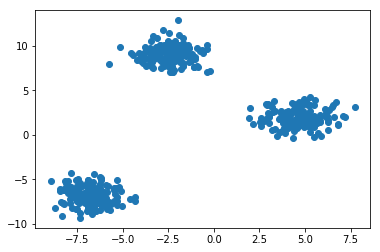

In [3]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

### Detección de anomalías con estimación de densidad

In [4]:
from sklearn.neighbors.kde import KernelDensity

# Estimacion de la densidad con un estimador de densidad con el kernel de Gauss
kde = KernelDensity(kernel='gaussian')
kde = kde.fit(X)
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [5]:
kde_X = kde.score_samples(X)
print(kde_X.shape)

(500,)


In [6]:
from scipy.stats.mstats import mquantiles
alfa_set = 0.95
tau_kde = mquantiles(kde_X, 1. - alfa_set)

In [7]:
n_muestras, n_caracteristicas = X.shape
X_range = np.zeros((n_caracteristicas, 2))
X_range[:, 0] = np.min(X, axis=0) - 1.
X_range[:, 1] = np.max(X, axis=0) + 1.

h = 0.1 
x_min, x_max = X_range[0]
y_min, y_max = X_range[1]
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

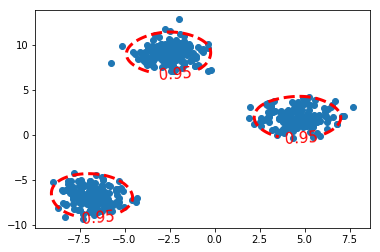

In [8]:
Z_kde = kde.score_samples(grid)
Z_kde = Z_kde.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_kde, levels=tau_kde, colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_kde[0]: str(alfa_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.show()

### One-Class SVM

El problema de la estimación basada en la densidad es que tienden a volverse ineficientes cuando aumenta la dimensionalidad de los datos. Es la llamada maldición de la dimensionalidad que afecta particularmente a estos algoritmos de estimación de densidad. El algoritmo one-class SVM puede usarse en tales casos.


In [9]:
from sklearn.svm import OneClassSVM


In [10]:
nu = 0.05  # La teoría dice que debería ser un límite superior de la fracción de valores atípicos.
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)
ocsvm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [11]:
X_outliers = X[ocsvm.predict(X) == -1]

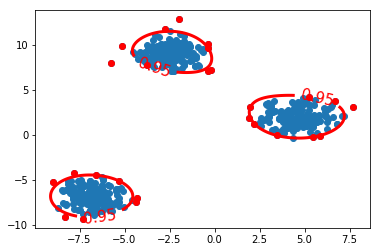

In [12]:
Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_ocsvm, levels=[0], colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={0: str(alfa_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red')
plt.show()

### Vectores de soporte-outliers

Son los  llamados vectores de soporte de one-class SVM  que forman los valores atípicos.



In [13]:
X_SV = X[ocsvm.support_]
n_SV = len(X_SV)
n_outliers = len(X_outliers)

print('{0:.2f} <= {1:.2f} <= {2:.2f}?'.format(1./n_muestras*n_outliers, nu, 1./n_muestras*n_SV))

0.05 <= 0.05 <= 0.06?


Solo los vectores de soporte involucrados en la función de decisión de One-class SVM.

* Grafican los conjuntos de niveles de la función de decisión One-Class SVM
* Enfatiza los vectores de soporte.

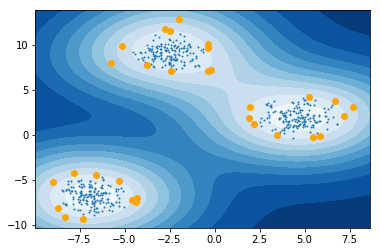

In [14]:
plt.figure()
plt.contourf(xx, yy, Z_ocsvm, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_SV[:, 0], X_SV[:, 1], color='orange')
plt.show()

1 .Cambia el parámetro `gamma` y vea su influencia en la suavidad (smoothness) de la función de decisión.

In [15]:
# Tu solucion

### Isolation forest

Isolation Forest es un algoritmo de detección de anomalías basado en árboles. El algoritmo construye una serie de árboles aleatorios y el razonamiento es que si una muestra se aísla, debe estar sola en una hoja después de muy pocas divisiones aleatorias. Isolation Forest construye una puntuación de anomalía basada en la profundidad del árbol en el que terminan las muestras.

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
iforest = IsolationForest(n_estimators=300, contamination=0.10)
iforest = iforest.fit(X)

/home/clara/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/clara/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


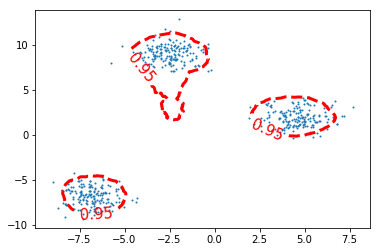

In [18]:
Z_iforest = iforest.decision_function(grid)
Z_iforest = Z_iforest.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_iforest,
                  levels=[iforest.threshold_],
                  colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15,
           fmt={iforest.threshold_: str(alfa_set)})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.show()

2 .Ilustra gráficamente la influencia del número de árboles en la suavidad(smoothness) de la función de decisión? 

In [19]:
# Tu solucion

Ahora aplicaremos el algoritmo IsolationForest para localizar dígitos escritos de una manera no convencional.

In [20]:
from sklearn.datasets import load_digits
digitos = load_digits()

In [25]:
imagenes = digitos.images
etiquetas = digitos.target
imagenes.shape

(1797, 8, 8)

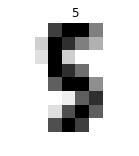

In [26]:
i = 102
plt.figure(figsize=(2, 2))
plt.title('{0}'.format(etiquetas[i]))
plt.axis('off')
plt.imshow(imagenes[i], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Para usar las imágenes como conjunto de entrenamiento necesitamos aplanar las imágenes.

In [27]:
n_muestras = len(digitos.images)
data = digitos.images.reshape((n_muestras, -1))

In [28]:
data.shape

(1797, 64)

In [29]:
X = data
y = digitos.target

In [30]:
X.shape

(1797, 64)

Nos centramos en el número 5

In [31]:
X_5 = X[y == 5]

In [32]:
X_5.shape

(182, 64)

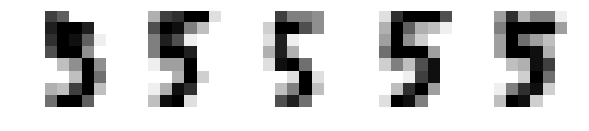

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for ax, x in zip(axes, X_5[:5]):
    img = x.reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

Usemos IsolationForest para encontrar el 5% de las imágenes más atípicas.

In [34]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.05)
iforest = iforest.fit(X_5)

Calculamos el nivel de "anomalía" con `iforest.decision_function`. Cuanto más bajo, más atípico.

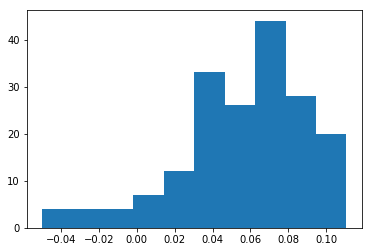

In [35]:
iforest_X = iforest.decision_function(X_5)
plt.hist(iforest_X);

Vamos a trazar los inliers más fuertes


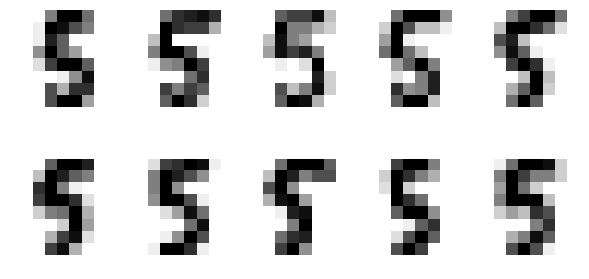

In [36]:
X_inliers = X_5[np.argsort(iforest_X)[-10:]]
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in zip(range(len(X_inliers)), axes.ravel()):
    ax.imshow(X_inliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

Vamos a trazar los outliers más fuertes

/home/clara/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


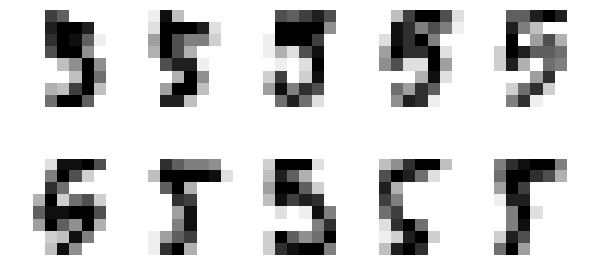

In [37]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
X_outliers = X_5[iforest.predict(X_5) == -1]

for i, ax in zip(range(len(X_outliers)), axes.ravel()):
    ax.imshow(X_outliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

3 .Ejecuta el mismo análisis con todos los otros dígitos

In [39]:
# Tu solucion